# Conditional variational autoencoder with Lightning

Starting with a VAE model, the goal of this notebook is to build a conditional VAE (CVAE) model. For an introduction on VAEs, check out the blog of Alexander Van de Kleut ([link](https://avandekleut.github.io/vae/), [github](https://github.com/avandekleut/avandekleut.github.io/blob/master/_posts/2020-05-14-vae.md)). His VAE model is also the basis for building the CVAE model in this notebook.

In [2]:
import torch

digits = torch.tensor([0,1,2,3])
torch.nn.functional.one_hot(digits, 10)

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import lightning.pytorch as pl

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from utils import plot_latent

# Loading data

In [ ]:
device = "cuda" # Use "cpu" if no GPU is available.

# Creating a dataloader
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('/scratch/trose/mnist',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=128,
        shuffle=True)

## Non-lightning of the VAE

In [16]:
# Code from: https://github.com/avandekleut/avandekleut.github.io/blob/master/_posts/2020-05-14-vae.md
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims, device):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        
        self.kl = 0
        self.device = device

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z
    
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims, device):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims, device)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)
    
def train_vae(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm(range(epochs)):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder


In [19]:
latent_dims = 2
vae = VariationalAutoencoder(latent_dims, device).to(device) # GPU
vae = train_vae(vae, data)

100%|██████████| 20/20 [01:48<00:00,  5.43s/it]


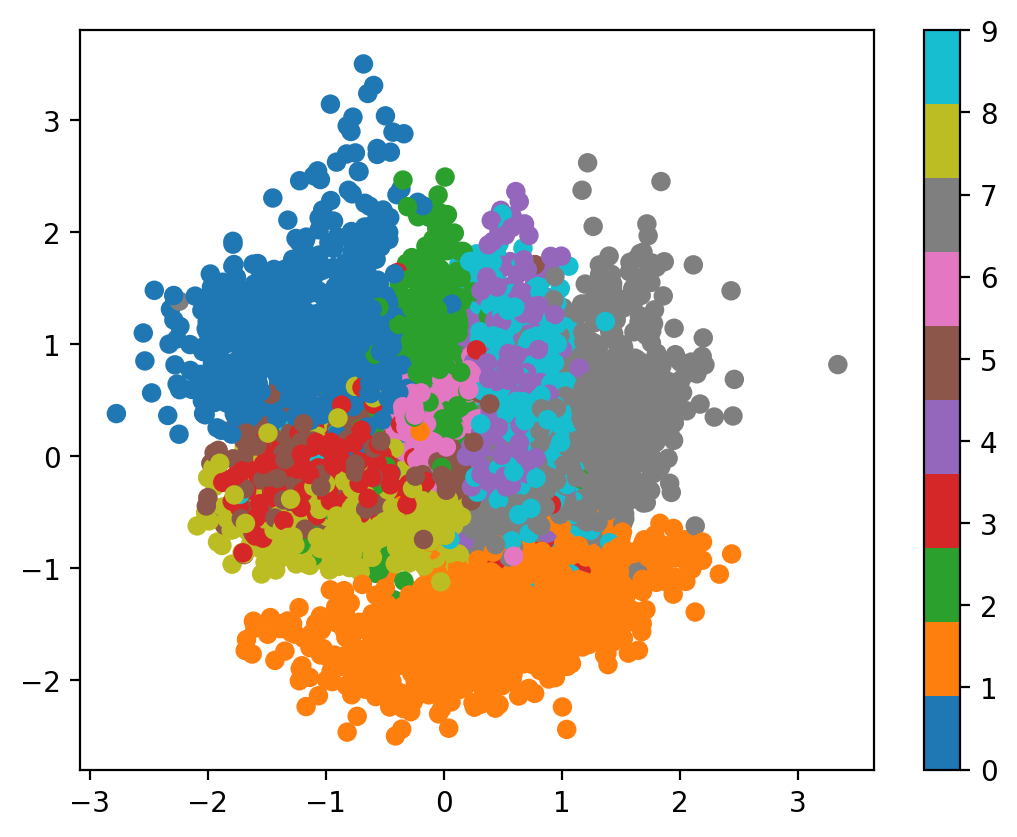

In [20]:
plot_latent(vae, data)

## Non-lightning CVAE

Now we want to turn the model into a CVAE. This means we condition on the label (a great explanation of CVAEs can be found [here](https://theaiacademy.blogspot.com/2020/05/understanding-conditional-variational.html)). In this case the number that is drawn on each image. This number is also provided by the dataloader. The label will be provided to the Encoder and Decoder as an additional input. In the code below all changes have been made to the original VAE model to create a CVAE model.

In [11]:
class CondVariationalEncoder(nn.Module):
    
    # The encoder gets the label as an one-hot encoding
    def __init__(self, latent_dims, n_classes):
        super(CondVariationalEncoder, self).__init__()
        # The dimensions of the one-hot encoding are added concatenated to the input
        self.linear1 = nn.Linear(784 + n_classes, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0
    
    # The labels are provided as variable `y`
    def forward(self, x, y):
        x = torch.flatten(x, start_dim=1)
        x = x.view(-1, 1*28*28)
        # Here the label one-hot encoding is concatenated to the image
        x = F.relu(self.linear1(torch.cat((x,y),dim=1)))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z
    
    
class CondVariationalDecoder(nn.Module):
    
    # The decoder gets the label as an one-hot encoding
    def __init__(self, latent_dims, n_classes):
        super(CondVariationalDecoder, self).__init__()
        # The dimensions of the one-hot encoding are added concatenated to the input
        self.linear1 = nn.Linear(latent_dims + n_classes, 512)
        self.linear2 = nn.Linear(512, 784)
        
    # Labels are provided as variable `y`
    def forward(self, z, y):
        # Here the label one-hot encoding is concatenated to the image
        z = F.relu(self.linear1(torch.cat((z,y),dim=1)))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

In [12]:
# The full CVAE model also forwards the integer labels
class CondVariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims, n_classes):
        super(CondVariationalAutoencoder, self).__init__()
        self.encoder = CondVariationalEncoder(latent_dims, n_classes)
        self.decoder = CondVariationalDecoder(latent_dims, n_classes)
    
    def forward(self, x, y):
        z = self.encoder(x, y)
        return self.decoder(z, y)

In [13]:
def train(autoencoder, data, epochs=20, n_classes=10):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm(range(epochs)):
        for x, y in data:
            x = x.to(device) # GPU
            number = torch.nn.functional.one_hot(torch.tensor(y), num_classes=n_classes).to(device)
            opt.zero_grad()
            x_hat = autoencoder(x, number)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
        print(loss)
    return autoencoder

In [30]:
# Model training

# We also use two latent dimensions for a simple visualization of the latent space
# Changin the number of latent dimensions will break the later plotting function
latent_dims=2
cvae = CondVariationalAutoencoder(latent_dims, n_classes=10).to(device) # GPU
cvae = train(cvae, data, n_classes=10)

  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_209/991955673.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  number = torch.nn.functional.one_hot(torch.tensor(y), num_classes=n_classes).to(device)
  5%|▌         | 1/20 [00:05<01:37,  5.13s/it]

tensor(3488.6538, device='cuda:0', grad_fn=<AddBackward0>)


 10%|█         | 2/20 [00:10<01:33,  5.17s/it]

tensor(3181.7263, device='cuda:0', grad_fn=<AddBackward0>)


 15%|█▌        | 3/20 [00:15<01:27,  5.17s/it]

tensor(3284.9121, device='cuda:0', grad_fn=<AddBackward0>)


 20%|██        | 4/20 [00:20<01:22,  5.16s/it]

tensor(3248.4434, device='cuda:0', grad_fn=<AddBackward0>)


 25%|██▌       | 5/20 [00:25<01:17,  5.16s/it]

tensor(3118.2791, device='cuda:0', grad_fn=<AddBackward0>)


 30%|███       | 6/20 [00:30<01:12,  5.15s/it]

tensor(3045.3452, device='cuda:0', grad_fn=<AddBackward0>)


 35%|███▌      | 7/20 [00:36<01:06,  5.14s/it]

tensor(3092.6182, device='cuda:0', grad_fn=<AddBackward0>)


 40%|████      | 8/20 [00:41<01:01,  5.15s/it]

tensor(3186.7620, device='cuda:0', grad_fn=<AddBackward0>)


 45%|████▌     | 9/20 [00:46<00:56,  5.12s/it]

tensor(3138.2676, device='cuda:0', grad_fn=<AddBackward0>)


 50%|█████     | 10/20 [00:51<00:51,  5.11s/it]

tensor(2895.2561, device='cuda:0', grad_fn=<AddBackward0>)


 55%|█████▌    | 11/20 [00:56<00:45,  5.10s/it]

tensor(3039.9673, device='cuda:0', grad_fn=<AddBackward0>)


 60%|██████    | 12/20 [01:01<00:40,  5.11s/it]

tensor(2739.4377, device='cuda:0', grad_fn=<AddBackward0>)


 65%|██████▌   | 13/20 [01:06<00:35,  5.12s/it]

tensor(2882.8574, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████   | 14/20 [01:12<00:31,  5.18s/it]

tensor(2991.8770, device='cuda:0', grad_fn=<AddBackward0>)


 75%|███████▌  | 15/20 [01:17<00:26,  5.21s/it]

tensor(2901.7737, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████  | 16/20 [01:22<00:20,  5.24s/it]

tensor(2982.5969, device='cuda:0', grad_fn=<AddBackward0>)


 85%|████████▌ | 17/20 [01:27<00:15,  5.27s/it]

tensor(2858.4517, device='cuda:0', grad_fn=<AddBackward0>)


 90%|█████████ | 18/20 [01:33<00:10,  5.22s/it]

tensor(2809.3579, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████▌| 19/20 [01:38<00:05,  5.17s/it]

tensor(2951.8179, device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 20/20 [01:43<00:00,  5.16s/it]

tensor(3010.3928, device='cuda:0', grad_fn=<AddBackward0>)


In [21]:
# In this plotting function we create a grid in the latent space and use this as an input for the decoder
# Additionally, the variable `number` we provide the interger we want the model to generate
def plot_reconstructed(autoencoder, r0=(-5, 5), r1=(-5, 5), n=12, number=2, device='cuda'):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, a in enumerate(np.linspace(*r1, n)):
        for j, b in enumerate(np.linspace(*r0, n)):
            
            z = torch.Tensor([[a, b]]).to(device)
            # One-hot encoding of the integer
            y = torch.nn.functional.one_hot(torch.tensor([number]), num_classes=10).to(device)
            x_hat = autoencoder.decoder(z, y)
            
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

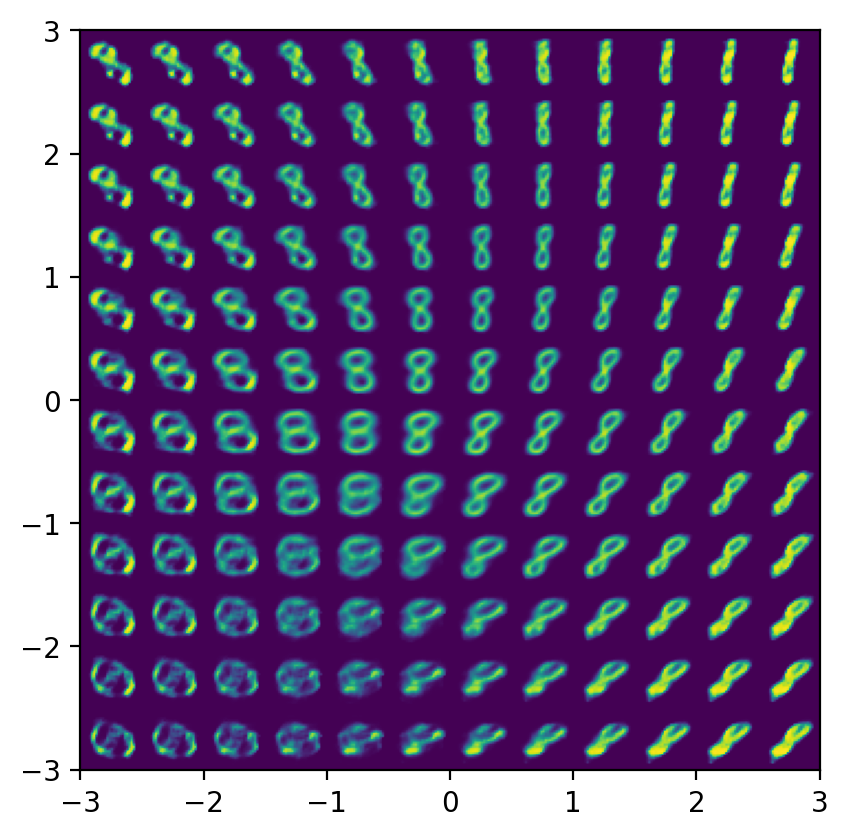

In [49]:
# Generating a variety of 8's from different positions in the latent space.

# Since the VAE loss pushed the model towards a standard normal distribution in the latent space 
# we can just use a grid centered around 0
plot_reconstructed(cvae, r0=(-3, 3), r1=(-3, 3), number=8)

In [50]:
def plot_latent_cvae(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device), torch.nn.functional.one_hot(torch.tensor(y), num_classes=10).to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

Plotting the output of the encoder using the training data, 
we can see that the model was able to condition on the integer.
Clusters of integers cannot be found in the distribution anymore. Compare this to the latens space of the VAE model above.

/tmp/ipykernel_209/1995175506.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = autoencoder.encoder(x.to(device), torch.nn.functional.one_hot(torch.tensor(y), num_classes=10).to(device))


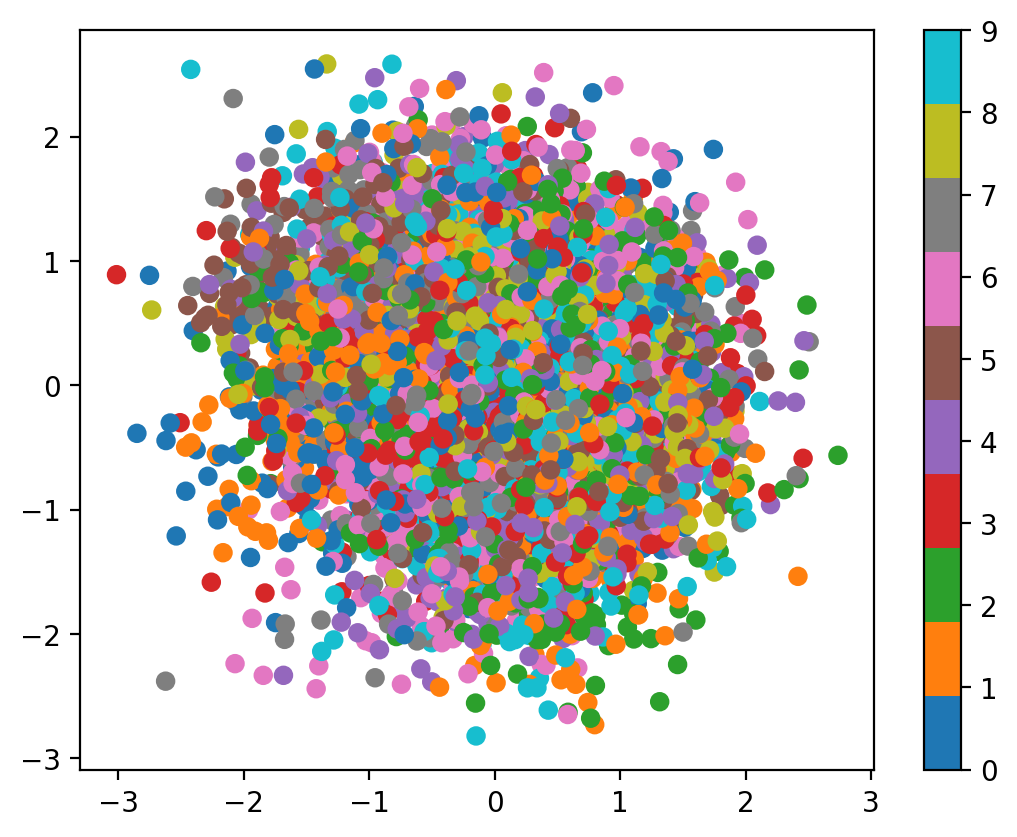

In [51]:
plot_latent_cvae(cvae, data)

## Lightning CVAE

Now we use the [PyTorch lightning framework](https://lightning.ai/docs/pytorch/stable/) to simplyfy training of the model. This is especially useful for hyperparameter tuning.

In [28]:
# First, we define Lightning module for the CVAE model
class CVAEModel(pl.LightningModule):
    # In the constructor we just use the previously defined CVAE model and number of classes
    def __init__(self, latent_dims, n_classes):
        super().__init__()
        self.cvae = CondVariationalAutoencoder(latent_dims, n_classes)
        self.n_classes = n_classes

    # Lightning requires a training step function in which the forward step is executed and loss calculated
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_oh = torch.nn.functional.one_hot(y, num_classes=self.n_classes)
        
        
        x_hat = self.cvae(x, y_oh)
        loss = loss = ((x - x_hat)**2).sum() + self.cvae.encoder.kl
        
        # For to see the loss during training, we add the current loss to the logger
        self.log('Training loss', loss, on_step=False, on_epoch=True, logger=False, prog_bar=True)
        
        return loss
    
    # Defining the optimizer
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)
    


In [29]:
# Training of the model
latent_dims=2
model = CVAEModel(latent_dims=latent_dims, n_classes=10)

trainer = pl.Trainer(devices=1, accelerator='gpu', max_epochs=20)
trainer.fit(model, data)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                       | Params
----------------------------------------------------
0 | cvae | CondVariationalAutoencoder | 817 K 
----------------------------------------------------
817 K     Trainable params
0         Non-trainable params
817 K     Total params
3.272     Total estimated model params size (MB)
/home/trose/.conda/envs/torch-gpuCUDA12/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 19: 100%|██████████| 469/469 [00:05<00:00, 78.40it/s, v_num=2, Training loss=4.7e+3] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 469/469 [00:06<00:00, 77.95it/s, v_num=2, Training loss=4.7e+3]


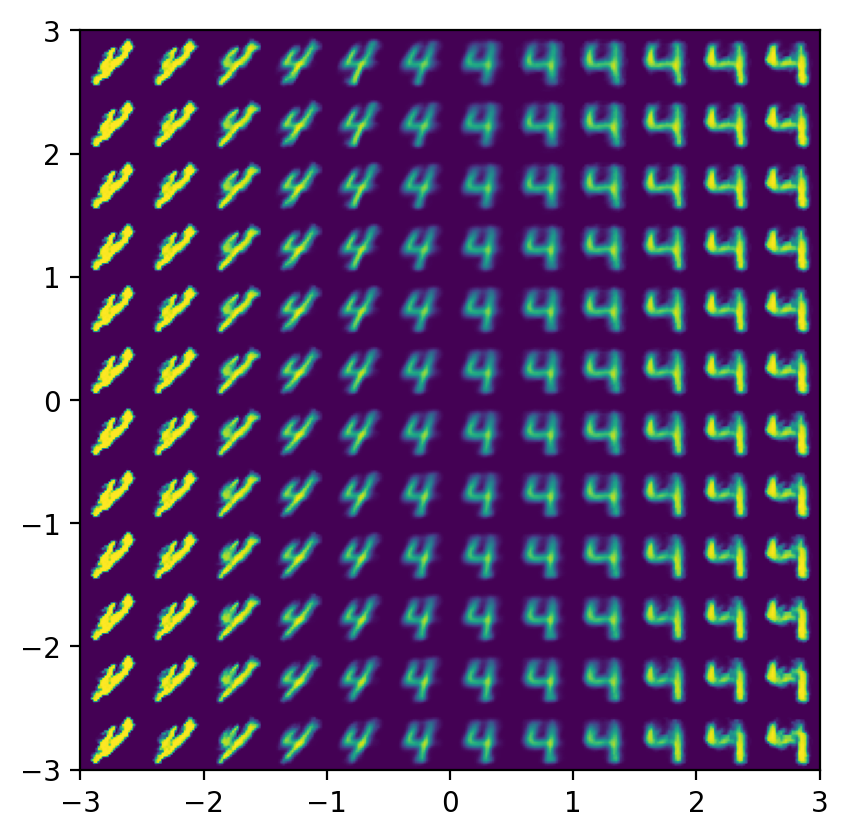

In [30]:
# Lightning is sending the model to the cpu after training, therefore we need to send it back to the gpu
model.to('cuda')
# Visualization of the latent space as shown previously after training
plot_reconstructed(model.cvae, r0=(-3, 3), r1=(-3, 3), number=4, device='cuda')